In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import mr_forecast as mr
from astropy.io import ascii
from scipy.optimize import root_scalar

%matplotlib inline

## Definitions of fields can be found at:
### confirmed planets:
https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
### KOIs:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")
print(KOIs)
print(len(KOIs.colnames))
print(KOIs.colnames)

 kepid   kepoi_name  kepler_name  ...   koi_pmass_err1     koi_pmass_err2  
-------- ---------- ------------- ... ------------------ ------------------
 1026957  K00958.01            -- ...  5.769464972554899  3.244408578305821
 1161345  K00984.01            -- ...  6.326092545818279 3.5574232654922424
 1429589  K04923.01            -- ... 1.5735103860765358 0.7378008287493754
 1431122  K00994.01            -- ...  2.419108737036141 1.0891220900035181
 1432789  K00992.01  Kepler-745 b ...  5.964185807741979  3.027858259246558
 1432789  K00992.02            -- ...  2.437079035986733 1.0697247065679856
 1717722  K03145.01            -- ... 2.6787928971009194 1.3399128949332408
 1717722  K03145.02            -- ... 1.3217080679402717 0.6511151044108447
 1718189  K00993.03            -- ... 3.0588005877402042 1.4588377614817154
 1718189  K00993.02  Kepler-262 b ... 2.9891737858212397  1.378072373671277
     ...        ...           ... ...                ...                ...
12645057  K0

# Constraints on hypothetical in-between planets

In [55]:
# For all the systems with 2+ planets, bracket Rp, P of a planet between each two observed.

# Relevant columns:
# KOIs('kepid')

# Directly observed:
# KOIs('koi_steff') [K]
# KOIs('koi_slogg') [log10cm/s]
# KOIs('koi_ror')
# KOIs('koi_period') [days] # Will bracket P_target

# Isochrone model-dependent:
# KOIs('koi_srad') [Rsun]
# KOIs('koi_smass') [Msun]
# KOIs('koi_prad') [Rearth]
# KOIs('koi_insol') [Searth]
# KOIs('koi_sma') [AU] # Will bracket a_target

# Forecaster-modeled:
# KOIs('koi_pmass') [Mearth]

# Will be calculated:
# Mutual Hill radii: will bracket Mp_target

# Will be reverse-Forecaster modeled:
# Brackets Rp_target

# want an array that looks like:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr

constraints = np.zeros((1,14))

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
#print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

#print(len(unique_kepid_70))
#print(len(unique_kepid_30))

kepids_toloop = unique_kepid
#features = mod_features
#means = np.mean(features,axis=0)
#sigmas = np.std(features,axis=0)
savename = "./realPlanets_obs/realKOIs_hypotheticalConstraints.txt"


for ID in kepids_toloop:
    print(ID)
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #constrain planet between star and 1st observed planet
    # The constraint here: we want the largest allowable planet for which the star's Roche limit 
    # exceeds Rstar + Rp.
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    thisSystem_idxs = thisSystem_idxs[sort]
    Ps = KOIs['koi_period'][thisSystem_idxs]
    count = KOIs['koi_count'][thisSystem_idxs[0]]
    Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Msun to Earth masses
    Rstar = KOIs['koi_srad'][thisSystem_idxs[0]] * 109.2 # Rsun to Earth radii
    P_innermost = KOIs['koi_period'][thisSystem_idxs[0]]    

    
    constrainedPlanet = np.zeros((14))
    constrainedPlanet[0] = ID
    constrainedPlanet[1] = 0
    constrainedPlanet[2] = 1
    constrainedPlanet[3] = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032
    constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[0]]
    # in units of Rearth**3 Mearth**-1 d**-2
    G_ = 6.674e-11 * (6371e3)**-3 * 5.972e24 * 86400**2
    constrainedPlanet[5] = np.sqrt( (4*np.pi**2 * Rstar**3) / (G_*Mstar) )
    constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[0]]
            
    a_inner = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032 #convert solrad to AU
    a_outer = KOIs['koi_sma'][thisSystem_idxs[0]]
            
    m_inner = Mstar
    m_outer = KOIs['koi_pmass'][thisSystem_idxs[0]]
            
    a_allow = np.linspace(a_inner, a_outer, 100)
    #mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
    mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer

    # eliminate negative masses
    a_allow = a_allow[mmax_fromouter > 0]
    mmax_fromouter = mmax_fromouter[mmax_fromouter > 0]
    
    rmax_fromouter = np.zeros_like(mmax_fromouter)
    rRoche = np.zeros_like(mmax_fromouter)
    for i in range(len(mmax_fromouter)):
        try:
            rmax_fromouter[i], Rplus, Rminus = mr.Mstat2R(mean=mmax_fromouter[i], std=0.01, unit='Earth', sample_size=100)
            
        except TypeError:
            #print("mmax is {0}".format(mmax_fromouter[i]))
            rmax_fromouter[i] = 1000
            Rplus = 0
            Rminus= 0
            #print(mmax_fromouter[i])
        rRoche[i] = rmax_fromouter[i] * ( 2 * (Mstar/mmax_fromouter[i]))**(1./3.)
    
    try:
        mmax = np.max(mmax_fromouter[rRoche > a_inner])
        Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
    except ValueError:
        mmmax = 0
        Rmedian = 0
        Rplus = 0
        Rminus = 0
    except TypeError:
        print("mmax is {0}".format(mmax))
        Rmedian = 1000
        Rplus = 0
        Rminus= 0
    """
    #print(rRoche)
    fig,axes = plt.subplots(1,2,figsize=(16,6))
    #axes[0].plot(a_allow,mmax_frominner,'b-',lw=1)
    axes[0].plot(a_allow,mmax_fromouter,'r-',lw=1)
    axes[0].plot((rRoche*((6371e3)/(1.496e11))),mmax_fromouter,'g-',lw=1)
    axes[0].axvline(a_inner,color='b',ls=':')
    axes[0].axvline(a_outer,color='r',ls=':')

    axes[0].axhline(m_inner,color='b',ls=':')
    axes[0].axhline(m_outer,color='r',ls=':')
    axes[0].axhline(mmax,color='g',ls='-')

    axes[0].set_xlabel("a [AU]")
    axes[0].set_ylabel("m_max [Mearth]")
    axes[0].set_title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,"star","0"))
    axes[0].set_xlim(0,a_outer*1.1)
    
    axes[1].plot(mmax_fromouter,(rRoche*((6371e3)/(1.496e11)))+a_allow,'g-',lw=1)
    axes[1].axhline(a_inner,color='b',ls=':')
    axes[1].set_xlabel('m_max [Mearth]')
    axes[1].set_ylabel('rRoche + a [AU]')
    
    plt.show()
    """
    #print(mmax_fromouter)
    #print(mmax)
    #print(Rmedian)
    constrainedPlanet[7] = mmax
    constrainedPlanet[8] = Rmedian
    constrainedPlanet[9] = Rplus
    constrainedPlanet[10] = Rminus
    
    constrainedPlanet[11] = Rmedian/Rstar
    constrainedPlanet[12] = Rplus/Rstar
    constrainedPlanet[13] = Rminus/Rstar
    
    constraints = np.vstack((constraints,constrainedPlanet))
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 1:
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]
        
        Ps = KOIs['koi_period'][thisSystem_idxs]
        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Earth masses
        
        for j in range(0,count-1):
            constrainedPlanet = np.zeros((14))
            constrainedPlanet[0] = ID
            constrainedPlanet[1] = j+1
            constrainedPlanet[2] = j+2
            constrainedPlanet[3] = KOIs['koi_sma'][thisSystem_idxs[j]]
            constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            constrainedPlanet[5] = KOIs['koi_period'][thisSystem_idxs[j]]
            constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[j+1]]
            
            a_inner = KOIs['koi_sma'][thisSystem_idxs[j]]
            a_outer = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            
            m_inner = KOIs['koi_pmass'][thisSystem_idxs[j]]
            m_outer = KOIs['koi_pmass'][thisSystem_idxs[j+1]]
            
            a_allow = np.linspace(a_inner, a_outer, 100)
            mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
            mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer
            
            # define function to find the root of
            def mmax_overall(a,a_inner,a_outer,m_inner,m_outer,Mstar):
                mmax_frominner = (Mstar/np.sqrt(3)) * ((a-a_inner)/(a+a_inner))**3 - m_inner
                mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a)/(a_outer+a))**3 - m_outer
            
                return mmax_frominner - mmax_fromouter
            
            try:
                a_mmax_obj = root_scalar(mmax_overall,args=(a_inner,a_outer,m_inner,m_outer,Mstar),bracket=(a_inner,a_outer))
                a_mmax = a_mmax_obj.root
                mmax = (Mstar/np.sqrt(3)) * ((a_mmax-a_inner)/(a_mmax+a_inner))**3 - m_inner
                
            except ValueError: #these are all gonna be negative anyway, doesn't really matter
                whichConstrains = np.argmin((mmax_frominner[0],mmax_fromouter[0]))
                if whichConstrains == 0:
                    mmax = np.max(mmax_frominner)
                else:
                    mmax = np.max(mmax_fromouter)
            
            #catch negative masses
            if mmax < 0:
                mmmax = 0
                Rmedian = 0
                Rplus = 0
                Rminus = 0
                
            else:
                try:
                    Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
                except TypeError:
                    print("mmax is {0}".format(mmax))
                    Rmedian = 1000
                    Rplus = 0
                    Rminus= 0
            
            constrainedPlanet[7] = mmax
            constrainedPlanet[8] = Rmedian
            constrainedPlanet[9] = Rplus
            constrainedPlanet[10] = Rminus
            
            constrainedPlanet[11] = Rmedian/Rstar
            constrainedPlanet[12] = Rplus/Rstar
            constrainedPlanet[13] = Rminus/Rstar
            
            """
            #print(mmax/317.8)#jupiter masses---i.e. is this a meaningful constraint?
            
            fig = plt.figure(figsize=(6,6))
            plt.plot(a_allow,mmax_frominner,'b-',lw=1)
            plt.plot(a_allow,mmax_fromouter,'r-',lw=1)
            plt.axvline(a_inner,color='b',ls=':')
            plt.axvline(a_outer,color='r',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            plt.axhline(m_inner,color='b',ls=':')
            plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.xlabel("a [AU]")
            plt.ylabel("m_max [Mearth]")
            plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+1))
            """
            
            constraints = np.vstack((constraints,constrainedPlanet))
constraints = constraints[1:]   
np.savetxt(savename,constraints,delimiter=" ",
           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",
           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")


1026957
1161345
1429589
1431122
1432789
1717722
1718189
1718958
1721157
1724719
1725016
1849702
1865042
1865864
1871056
1872821
1873513
1995519
1996180
2019199
2019477
2142522
2161536
2164169
2165002
2302548
2303903
2304320
2305866
2307199
2307415
2310993
2438264
2439243
2441495
2442448
2443393
2444412


KeyboardInterrupt: 

In [ ]:
print(np.shape(constraints))

fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(constraints[:,7]/317.8,range=(0,20),color='b',alpha=0.7)
axes[0].set_xlabel("Maximum mass in Mjup")
axes[1].hist(constraints[:,8]/11.209,range=(0,100),color='r',alpha=0.7)
axes[1].hist((constraints[:,8]+constraints[:,9])/11.209,range=(0,100),color='y',alpha=0.7)

axes[1].set_xlabel("Maximum radius in Rjup")
plt.show()

# Constrain the real target planets as if they weren't observed

In [57]:
# For all the systems with 2+ planets, bracket Rp, P of a planet between each two observed.

# Relevant columns:
# KOIs('kepid')

# Directly observed:
# KOIs('koi_steff') [K]
# KOIs('koi_slogg') [log10cm/s]
# KOIs('koi_ror')
# KOIs('koi_period') [days] # Will bracket P_target

# Isochrone model-dependent:
# KOIs('koi_srad') [Rsun]
# KOIs('koi_smass') [Msun]
# KOIs('koi_prad') [Rearth]
# KOIs('koi_insol') [Searth]
# KOIs('koi_sma') [AU] # Will bracket a_target

# Forecaster-modeled:
# KOIs('koi_pmass') [Mearth]

# Will be calculated:
# Mutual Hill radii: will bracket Mp_target

# Will be reverse-Forecaster modeled:
# Brackets Rp_target

# want an array that looks like:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr

constraints = np.zeros((1,14))

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
#print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

#print(len(unique_kepid_70))
#print(len(unique_kepid_30))

kepids_toloop = unique_kepid
#features = mod_features
#means = np.mean(features,axis=0)
#sigmas = np.std(features,axis=0)
savename = "./realPlanets_obs/realKOIs_targetConstraints.txt"


for ID in kepids_toloop:
    print(ID)
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #constrain planet between star and 1st observed planet
    # The constraint here: we want the largest allowable planet for which the star's Roche limit 
    # exceeds Rstar + Rp.
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    
    thisSystem_idxs = thisSystem_idxs[sort]
    Ps = KOIs['koi_period'][thisSystem_idxs]
    count = KOIs['koi_count'][thisSystem_idxs[0]]
    Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Msun to Earth masses
    Rstar = KOIs['koi_srad'][thisSystem_idxs[0]] * 109.2 # Rsun to Earth radii
    P_innermost = KOIs['koi_period'][thisSystem_idxs[0]]
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 1:
    
        constrainedPlanet = np.zeros((14))
        constrainedPlanet[0] = ID
        constrainedPlanet[1] = 0
        constrainedPlanet[2] = 2
        constrainedPlanet[3] = KOIs['koi_srad'][thisSystem_idxs[1]]/215.032 #AU
        constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[1]] #AU
        # in units of Rearth**3 Mearth**-1 d**-2
        G_ = 6.674e-11 * (6371e3)**-3 * 5.972e24 * 86400**2
        constrainedPlanet[5] = np.sqrt( (4*np.pi**2 * Rstar**3) / (G_*Mstar) )
        constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[1]]

        a_inner = KOIs['koi_srad'][thisSystem_idxs[1]]/215.032 #convert solrad to AU
        a_outer = KOIs['koi_sma'][thisSystem_idxs[1]]

        m_inner = Mstar
        m_outer = KOIs['koi_pmass'][thisSystem_idxs[1]]

        a_allow = np.linspace(a_inner, a_outer, 100)
        #mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
        mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer

        # eliminate negative masses
        a_allow = a_allow[mmax_fromouter > 0]
        mmax_fromouter = mmax_fromouter[mmax_fromouter > 0]

        rmax_fromouter = np.zeros_like(mmax_fromouter)
        rRoche = np.zeros_like(mmax_fromouter)
        for i in range(len(mmax_fromouter)):
            try:
                rmax_fromouter[i], Rplus, Rminus = mr.Mstat2R(mean=mmax_fromouter[i], std=0.01, unit='Earth', sample_size=100)

            except TypeError:
                print("mmax is {0}".format(mmax_fromouter[i]))
                rmax_fromouter[i] = 1000
                Rplus = 0
                Rminus= 0
                print(mmax_fromouter[i])
            rRoche[i] = rmax_fromouter[i] * ( 2 * (Mstar/mmax_fromouter[i]))**(1./3.)

        try:
            mmax = np.max(mmax_fromouter[rRoche > a_inner])
            Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
        except ValueError:
            mmmax = 0
            Rmedian = 0
            Rplus = 0
            Rminus = 0
        except TypeError:
            print("mmax is {0}".format(mmax))
            Rmedian = 1000
            Rplus = 0
            Rminus= 0
        """
        #print(rRoche)
        fig,axes = plt.subplots(1,2,figsize=(16,6))
        #axes[0].plot(a_allow,mmax_frominner,'b-',lw=1)
        axes[0].plot(a_allow,mmax_fromouter,'r-',lw=1)
        axes[0].plot((rRoche*((6371e3)/(1.496e11))),mmax_fromouter,'g-',lw=1)
        axes[0].axvline(a_inner,color='b',ls=':')
        axes[0].axvline(a_outer,color='r',ls=':')

        axes[0].axhline(m_inner,color='b',ls=':')
        axes[0].axhline(m_outer,color='r',ls=':')
        axes[0].axhline(mmax,color='g',ls='-')

        axes[0].set_xlabel("a [AU]")
        axes[0].set_ylabel("m_max [Mearth]")
        axes[0].set_title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,"star","0"))
        axes[0].set_xlim(0,a_outer*1.1)

        axes[1].plot(mmax_fromouter,(rRoche*((6371e3)/(1.496e11)))+a_allow,'g-',lw=1)
        axes[1].axhline(a_inner,color='b',ls=':')
        axes[1].set_xlabel('m_max [Mearth]')
        axes[1].set_ylabel('rRoche + a [AU]')

        plt.show()
        """

        constrainedPlanet[7] = mmax
        constrainedPlanet[8] = Rmedian
        constrainedPlanet[9] = Rplus
        constrainedPlanet[10] = Rminus
        
        constrainedPlanet[11] = Rmedian/Rstar
        constrainedPlanet[12] = Rplus/Rstar
        constrainedPlanet[13] = Rminus/Rstar

        constraints = np.vstack((constraints,constrainedPlanet))
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 2:
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Earth masses
        
        for j in range(0,count-2):
            constrainedPlanet = np.zeros((14))
            constrainedPlanet[0] = ID
            constrainedPlanet[1] = j+1
            constrainedPlanet[2] = j+3
            constrainedPlanet[3] = KOIs['koi_sma'][thisSystem_idxs[j]]
            constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[j+2]]
            constrainedPlanet[5] = KOIs['koi_period'][thisSystem_idxs[j]]
            constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[j+2]]
            
            a_inner = KOIs['koi_sma'][thisSystem_idxs[j]]
            a_outer = KOIs['koi_sma'][thisSystem_idxs[j+2]]
            
            m_inner = KOIs['koi_pmass'][thisSystem_idxs[j]]
            m_outer = KOIs['koi_pmass'][thisSystem_idxs[j+2]]
            
            a_allow = np.linspace(a_inner, a_outer, 100)
            mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
            mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer
            
            # define function to find the root of
            def mmax_overall(a,a_inner,a_outer,m_inner,m_outer,Mstar):
                mmax_frominner = (Mstar/np.sqrt(3)) * ((a-a_inner)/(a+a_inner))**3 - m_inner
                mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a)/(a_outer+a))**3 - m_outer
            
                return mmax_frominner - mmax_fromouter
            
            try:
                a_mmax_obj = root_scalar(mmax_overall,args=(a_inner,a_outer,m_inner,m_outer,Mstar),bracket=(a_inner,a_outer))
                a_mmax = a_mmax_obj.root
                mmax = (Mstar/np.sqrt(3)) * ((a_mmax-a_inner)/(a_mmax+a_inner))**3 - m_inner
                
            except ValueError: #these are all gonna be negative anyway, doesn't really matter
                whichConstrains = np.argmin((mmax_frominner[0],mmax_fromouter[0]))
                if whichConstrains == 0:
                    mmax = np.max(mmax_frominner)
                else:
                    mmax = np.max(mmax_fromouter)
            
            #catch negative masses
            if mmax < 0:
                mmmax = 0
                Rmedian = 0
                Rplus = 0
                Rminus = 0
                
            else:
                try:
                    Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
                except TypeError:
                    print("mmax is {0}".format(mmax))
                    Rmedian = 1000
                    Rplus = 0
                    Rminus= 0
            
            constrainedPlanet[7] = mmax
            constrainedPlanet[8] = Rmedian
            constrainedPlanet[9] = Rplus
            constrainedPlanet[10] = Rminus
            
            constrainedPlanet[11] = Rmedian/Rstar
            constrainedPlanet[12] = Rplus/Rstar
            constrainedPlanet[13] = Rminus/Rstar
                
            """
            #print(mmax/317.8)#jupiter masses---i.e. is this a meaningful constraint?
            
            fig = plt.figure(figsize=(6,6))
            plt.plot(a_allow,mmax_frominner,'b-',lw=1)
            plt.plot(a_allow,mmax_fromouter,'r-',lw=1)
            plt.axvline(a_inner,color='b',ls=':')
            plt.axvline(a_outer,color='r',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            plt.axhline(m_inner,color='b',ls=':')
            plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.xlabel("a [AU]")
            plt.ylabel("m_max [Mearth]")
            plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+2))
            """
            
            constraints = np.vstack((constraints,constrainedPlanet))
constraints = constraints[1:]
np.savetxt(savename,constraints,delimiter=" ",
           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",
           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")


1026957
1161345
1429589
1431122
1432789
1717722
1718189
1718958
1721157
1724719
1725016
1849702
1865042
1865864
1871056
1872821
1873513
1995519
1996180
2019199
2019477
2142522
2161536
2164169
2165002
2302548
2303903
2304320
2305866
2307199
2307415
2310993
2438264
2439243
2441495
2442448
2443393
2444412
2449431
2556650
2557816
2558163
2571238
2572029
2574338
2576962
2579043
2581554
2584163
2692377
2693736
2713049
2715135
2715695
2717158
2718778
2721030
2831055
2849140
2849805
2853029
2853093
2853446
2854698
2854914
2857607
2859893
2860656
2860866
2861298
2973386
2975770
2976017
2985767
2986833
2987027
2989404
2990873
2995392
2997459
3001955
3002478
3097926
3098605
3098810
3101178
3101923
3102384
3103212
3103227
3103473
3109550
3109930
3112129
3114167
3114811
3115833
3116412
3118797
3120355
3120904
3122872
3122913
3128552
3217264
3218908
3219643
3219995
3223433
3234598
3234843
3236705
3239171
3239671
3244792
3245969
3248501
3323887
3326377
3328080
3329204
3338885
3340165
3342794
3342970


7288306
7288444
7289139
7289317
7289338
7289577
7294743
7295235
7303253
7304449
7345248
7347246
7364176
7366258
7373451
7375348
7376983
7377343
7382313
7386827
7416016
7416306
7416646
7419318
7427764
7428736
7429240
7430034
7434875
7439316
7440715
7440748
7445445
7446631
7447200
7449136
7449541
7449554
7450747
7455287
7455981
7456001
7457296
7458762
7463685
7499398
7501646
7503885
7504778
7509886
7510820
7512982
7515212
7515336
7515679
7515762
7522911
7534267
7539277
7542813
7549209
7582689
7582691
7583650
7595157
7596240
7603200
7604328
7605093
7609674
7610663
7625138
7625143
7626370
7626506
7629518
7630229
7631138
7659389
7661893
7662502
7663405
7663691
7668416
7668663
7670943
7672097
7672215
7673192
7673841
7676423
7678434
7679812
7685981
7690782
7690844
7691260
7697103
7700622
7703882
7703955
7730747
7731281
7733731
7742408
7747091
7747425
7747457
7748487
7749002
7749773
7755636
7758018
7761545
7761918
7762153
7762723
7764367
7767162
7768451
7769819
7770901
7771181
7772914
7778427


10328458
10329196
10329469
10329835
10330115
10332883
10336951
10337258
10337517
10339000
10351231
10352333
10353968
10354039
10358759
10360722
10363115
10384298
10384798
10386922
10386984
10387792
10388286
10394802
10395381
10395543
10404582
10407482
10426656
10453009
10453588
10454313
10454632
10460629
10460984
10464050
10467714
10468885
10468940
10470779
10471515
10471621
10480915
10482160
10487228
10489206
10489345
10513530
10519727
10525027
10525049
10525077
10526549
10526887
10528068
10531955
10538176
10545066
10549023
10549902
10552151
10552263
10552611
10554999
10577994
10581308
10583066
10583761
10584140
10585749
10585852
10586004
10586208
10586744
10587105
10591855
10593535
10593626
10597693
10599206
10600261
10600955
10601163
10601284
10604521
10604592
10615440
10616679
10617017
10618044
10647452
10653179
10656823
10657406
10658177
10663396
10663738
10663976
10666592
10669994
10670119
10676014
10676750
10676824
10682541
10684670
10685764
10686864
10709622
10713616
10714072
1

(856, 14)


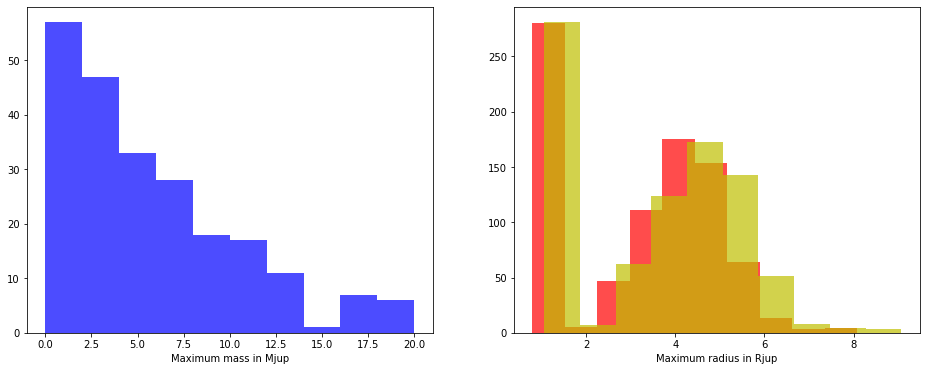

In [58]:
print(np.shape(constraints))

fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(constraints[:,7]/317.8,range=(0,20),color='b',alpha=0.7)
axes[0].set_xlabel("Maximum mass in Mjup")
axes[1].hist(constraints[:,8]/11.209,color='r',alpha=0.7)
axes[1].hist((constraints[:,8]+constraints[:,9])/11.209,color='y',alpha=0.7)

axes[1].set_xlabel("Maximum radius in Rjup")
plt.show()

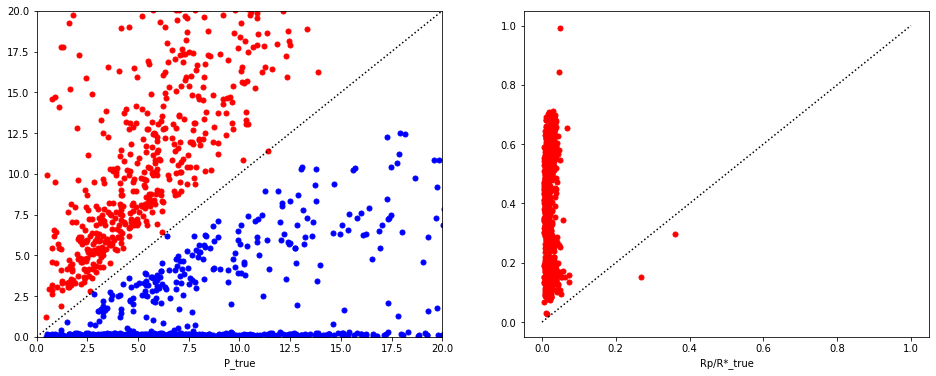

In [71]:
# Plot constraints vs. true

# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr
constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")

fig, axes = plt.subplots(1,2,figsize=(16,6))
for i in range(len(constraints)):
    ID = constraints[i,0]
    thisSys = KOIs[KOIs['kepid'] == ID]
    thisSys_P = np.array(thisSys['koi_period'])
    thisSys_Rp = np.array(thisSys['koi_prad'])[np.argsort(thisSys_P)]
    thisSys_ror = np.array(thisSys['koi_ror'])[np.argsort(thisSys_P)]
    thisSys_P = thisSys_P[np.argsort(thisSys_P)]
    
    innerplanetIdx = int(constraints[i,1])
    
    #axes[0].axvline(x=thisSys_P[innerplanetIdx],ymin=constraints[i,5],ymax=constraints[i,6],color='b',lw=0.5,alpha=0.5)
    
    axes[0].plot(thisSys_P[innerplanetIdx],constraints[i,5],color='b',marker='o',ms=5)
    axes[0].plot(thisSys_P[innerplanetIdx],constraints[i,6],color='r',marker='o',ms=5)
    
    #axes[1].axvline(x=thisSys_ror[innerplanetIdx],ymin=constraints[i,11]-constraints[i,13],ymax=constraints[i,11]+constraints[i,12],color='r',lw=1)
    
    axes[1].plot(thisSys_ror[innerplanetIdx],constraints[i,11]+constraints[i,12],color='r',marker='o',ms=5)
    #axes[1].plot(thisSys_ror[innerplanetIdx],constraints[i,11]-constraints[i,13],'bo')
    
    axes[0].set_xlabel("P_true")
    axes[1].set_xlabel("Rp/R*_true")
    
axes[0].plot(np.linspace(0,200,5),np.linspace(0,200,5),'k:')
axes[1].plot(np.linspace(0,1,5),np.linspace(0,1,5),'k:')

axes[0].set_xlim(0,20)
axes[0].set_ylim(0,20)
#axes[1].set_xlim(0,0.1)
#axes[1].set_ylim(0,200)
plt.show()

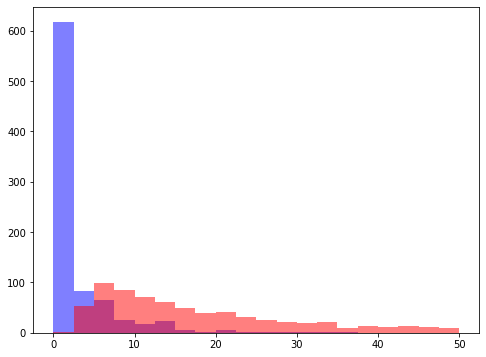

In [60]:
fig = plt.figure(figsize=(8,6))
plt.hist(constraints[:,5],bins=20,range=(0,50),color='b',alpha=0.5)
plt.hist(constraints[:,6],bins=20,range=(0,50),color='r',alpha=0.5)
plt.show()